In [1]:
import os
import argparse
import logging
logging.basicConfig(level=logging.DEBUG)
from common import find_mxnet, data, fit
from common.util import download_file
#from tf_iterators import *
import mxnet as mx
import numpy as np
import numpy 
from mxnet import nd
#from mxnet.module.module_tf import *

In [2]:
def cif100_iterator(data_dir,batch_size):
    train = mx.io.ImageRecordIter(
            path_imgrec         = os.path.join(data_dir, "train.rec"),
            label_width         = 1,
            data_name           = 'data',
            label_name          = 'softmax1_label',
            data_shape          = (3, 28, 28),
            batch_size          = batch_size,
            pad                 = 0,
            fill_value          = 127,  # only used when pad is valid
            rand_crop           = True,
            #max_random_scale    = 1.0,  # 480 with imagnet, 32 with cifar10 448 with birds 0.93
            #min_random_scale    = 0.53,  # 256.0/480.0
            #max_aspect_ratio    =  0.25,
            random_h            = 36,  # 0.4*90
            random_s            = 50,  # 0.4*127
            random_l            = 50,  # 0.4*127
            #max_rotate_angle    = 10,
            #max_shear_ratio     = 0.1, #
            rand_mirror         = True,
            shuffle             = True)
            #num_parts           = kv.num_workers,
            #part_index          = kv.rank)
    val = mx.io.ImageRecordIter(
            path_imgrec         = os.path.join(data_dir, "test.rec"),
            label_width         = 1,
            data_name           = 'data',
            label_name          = 'softmax1_label',
            batch_size          = batch_size,
            max_random_scale    = 1,  # 480 with imagnet, 32 with cifar10
            min_random_scale    = 1,  # 256.0/480.
            data_shape          = (3,28, 28),
            rand_crop           = False,
            rand_mirror         = False)
            #num_parts           = kv.num_workers,
            #part_index          = kv.rank)
    return train, val

In [11]:
class Cross_Entropy(mx.metric.EvalMetric):
    """Calculate accuracies of multi label"""

    def __init__(self):
        super(Cross_Entropy, self).__init__('cross-entropy')
    def update(self, labels, preds):
        mx.metric.check_label_shapes(labels, preds)
        label = labels[0].asnumpy()
        pred = preds[0].asnumpy()
        for i in range(label.shape[0]):
            prob = pred[i,numpy.int64(label[i])]
            if len(labels) == 1:
                self.sum_metric += (-numpy.log(prob)).sum()
        self.num_inst += label.shape[0]

In [4]:
image_shape = '3,28,28'
batch_size = 16
results_prefix='/home/ubuntu/results/'

data_dir='/home/ubuntu/data/cifar100'
train, val = cif100_iterator(data_dir,batch_size)
label_names = [train.provide_label[0][0]]
    
from importlib import import_module
net = import_module('symbols.td_resnet')
sym=net.get_unrolled_symbol(100, 14, image_shape,num_branch=3,num_step=5, conv_workspace=256,bottle_neck=True)
                        
#sym=net.get_symbol(100, 38, image_shape,hyper=True,scalar_gate=True,num_branch=2, conv_workspace=256,bottle_neck=True)
model_prefix='cif100_res38'

symbols/td_resnet.py:17: SyntaxWarning: name 'conv_w_dict' is assigned to before global declaration
  global conv_w_dict
symbols/td_resnet.py:18: SyntaxWarning: name 'count_dict' is assigned to before global declaration
  global count_dict
symbols/td_resnet.py:19: SyntaxWarning: name 'beta_dict' is assigned to before global declaration
  global beta_dict
symbols/td_resnet.py:20: SyntaxWarning: name 'gamma_dict' is assigned to before global declaration
  global gamma_dict
symbols/td_resnet.py:21: SyntaxWarning: name 'fc_w_dict' is assigned to before global declaration
  global fc_w_dict
symbols/td_resnet.py:22: SyntaxWarning: name 'fc_b_dict' is assigned to before global declaration
  global fc_b_dict


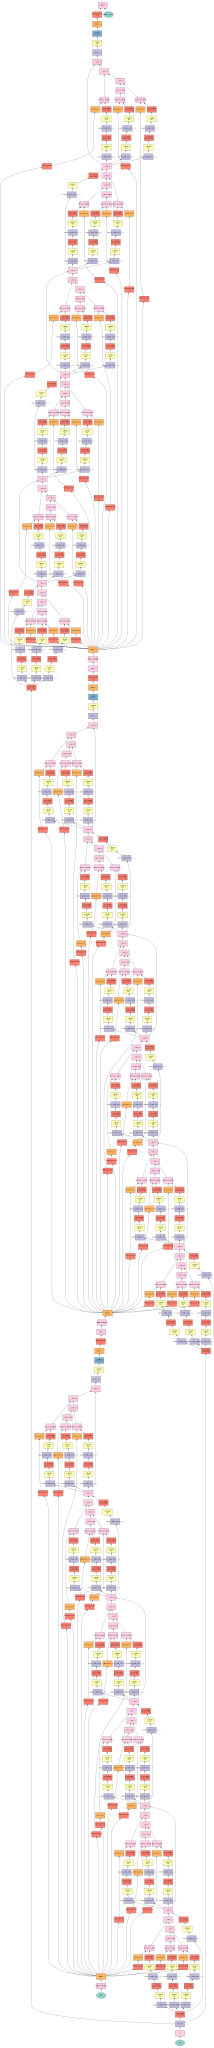

In [5]:
mx.viz.plot_network(sym)

In [6]:
# imagenet_weights= '/home/ubuntu/models/imagenet_r50-lr05'
# tornado_weights='/home/ubuntu/models/resnet-101'
# #model_prefix= 'tryhard-resnet'
# prefix = tornado_weights
# #prefix = model_prefix
# epoch=0
# save_dict = nd.load('%s-%04d.params' % (prefix, epoch))
# arg_params_imag = {}
# aux_params_imag = {}
# ext_check=['sc','fc1','data']
# imagenet_par=[]
# exact_check=['bn1_beta','bn1_gamma']
# for k, v in save_dict.items():
#     tp, name = k.split(':', 1)

#     if tp == 'arg':
#         arg_params_imag[name] = v
        
        
#         #print name
#         if not any(ext in name for ext in ext_check):
#             if not any(ext == name for ext in exact_check):
#                 imagenet_par.append(name)
#                 if init_2=='imagenet':
#                     arg_params_imag['_a_'+name] = v


#     if tp == 'aux':
#         aux_params_imag[name] = v
#         if init_2=='imagenet':
#             aux_params_imag['_a_'+name] = v
# del arg_params_imag['fc1_bias']
# del arg_params_imag['fc1_weight']



# #arg_params_imag.list_arguments


# #_a_bn_data_beta

# symlist=sym.list_arguments()
# gatelist=[s for s in symlist if 'gate' in s]

In [7]:
symlist=sym.list_arguments()
symlist

['data',
 'bn_data_gamma',
 'bn_data_beta',
 'conv0_2_weight',
 'stage1_unit1_bn1_0_gamma',
 'stage1_unit1_bn1_0_beta',
 'stage1_unit1_conv1_0_weight',
 'stage1_unit1_bn2_0_gamma',
 'stage1_unit1_bn2_0_beta',
 'stage1_unit1_conv2_0_weight',
 'conv0_1_weight',
 'conv0_0_weight',
 'prior',
 'stage1_unit1hyper_gate_0_weight',
 'stage1_unit1hyper_gate_0_bias',
 'stage1_unit1_bn1_1_gamma',
 'stage1_unit1_bn1_1_beta',
 'stage1_unit1_conv1_1_weight',
 'stage1_unit1_bn2_1_gamma',
 'stage1_unit1_bn2_1_beta',
 'stage1_unit1_conv2_1_weight',
 'stage1_unit1hyper_gate_1_weight',
 'stage1_unit1hyper_gate_1_bias',
 'stage1_unit1_bn1_2_gamma',
 'stage1_unit1_bn1_2_beta',
 'stage1_unit1_conv1_2_weight',
 'stage1_unit1_bn2_2_gamma',
 'stage1_unit1_bn2_2_beta',
 'stage1_unit1_conv2_2_weight',
 'stage1_unit1hyper_gate_2_weight',
 'stage1_unit1hyper_gate_2_bias',
 'stage1_unit1_bn1_sc_gamma',
 'stage1_unit1_bn1_sc_beta',
 'stage1_unit1_sc_weight',
 'stage1_unit2_bn1_0_gamma',
 'stage1_unit2_bn1_0_beta',
 '

In [8]:
fixed=None
arg_params=None
aux_params=None
ctx=[mx.gpu(0)]
mod = mx.mod.Module(sym, label_names=label_names,fixed_param_names=fixed,context=ctx)
#
checkpoint_path=results_prefix+model_prefix
#checkpoint = mx.callback.module_checkpoint(mod,model_prefix)
mod.bind(data_shapes=train.provide_data, label_shapes=train.provide_label)
mod.init_params(initializer=mx.initializer.Uniform(0.01), arg_params=arg_params, aux_params=aux_params,
                    allow_missing=True, force_init=False)

checkpoint = mx.callback.module_checkpoint(mod,checkpoint_path,period=5)
#lr_schedule it isimilar to the CIFAR100 schedule but half length of the steps
schedule = [40000,60000,90000]
begin_epoch=0

In [12]:
mod.fit(train,
         eval_data=val,
        
         eval_metric=[mx.metric.Accuracy(),Cross_Entropy()],

         batch_end_callback = [mx.callback.log_train_metric(50),mx.callback.Speedometer(batch_size,100)],
         epoch_end_callback=checkpoint,
         allow_missing=False,
         begin_epoch=begin_epoch,
         #log_prefix = model_prefix,
         optimizer_params={'learning_rate':0.1, 'momentum': 0.9,'wd':0.0004, 'lr_scheduler': mx.lr_scheduler.MultiFactorScheduler(step=schedule,factor=0.1) },
         num_epoch=90)

INFO:root:Iter[0] Batch[0] Train-accuracy=0.062500
INFO:root:Iter[0] Batch[0] Train-cross-entropy=4.734589
INFO:root:Iter[0] Batch[50] Train-accuracy=0.017157
INFO:root:Iter[0] Batch[50] Train-cross-entropy=5.425519


KeyboardInterrupt: 

In [ ]:
mod.get_params()[0]['prior'].asnumpy()

In [ ]:
y=[[1,1,1],[2,2,2],[3,3,3]]
for i in range(0,3):
    
    a.append(y[i])

In [ ]:
a

In [ ]:
zip(*a)[0]

In [ ]:
b={}
b['mona']=3

In [ ]:
b

In [ ]:
'mona' in b

In [ ]:
mona={}
mena={}
global mona

In [ ]:
def printmona():
    print mena
printmona()    

In [ ]:
count_dict